In [18]:
%matplotlib notebook
from time import time
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from scipy.sparse import linalg, eye
from scipy.linalg import eigh, svd, qr, solve
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances, rbf_kernel
from sklearn.datasets import fetch_mldata

random.seed(42)
N = 400

digits = fetch_mldata('MNIST original')
X = digits.data
indices = list(range(len(X)))
random.shuffle(indices)
X = X[indices[:N],:]

print(X.shape)
y = digits.target
y = y[indices[:N]]
n_samples, n_features = X.shape
n_neighbors = 90


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_2D_embedding(X, title=None, subpId=111):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    #plt.figure()
    ax = plt.subplot(subpId)
    print(X.shape)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 6})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
        
def plot_3D_embedding(X, title=None, subpId=111):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
   
    ax = plt.subplot(subpId, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1],X[i,2], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 6})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

(400, 784)


In [25]:
def lle(X, k = 30, dim = 3, metric_='euclidean'):
    print(metric_)
    knn = NearestNeighbors(n_neighbors= k + 1,metric = metric_).fit(X)
    X = knn._fit_X
    ind = knn.kneighbors(X, return_distance=False)[:,1:] #Remove sample itself
    samples = X.shape[0]
    W = manifold.locally_linear.barycenter_kneighbors_graph(X,k)
    W = W.toarray()
    M = np.eye(len(X)) - W

    M = np.dot(M.T,M)
    eigen_values, eigen_vectors = eigh(M, eigvals=(1, dim), overwrite_a=True)
    index = np.argsort(np.abs(eigen_values))
    return eigen_vectors[:, index], M, np.sum(eigen_values[1:])

<IPython.core.display.Javascript object>


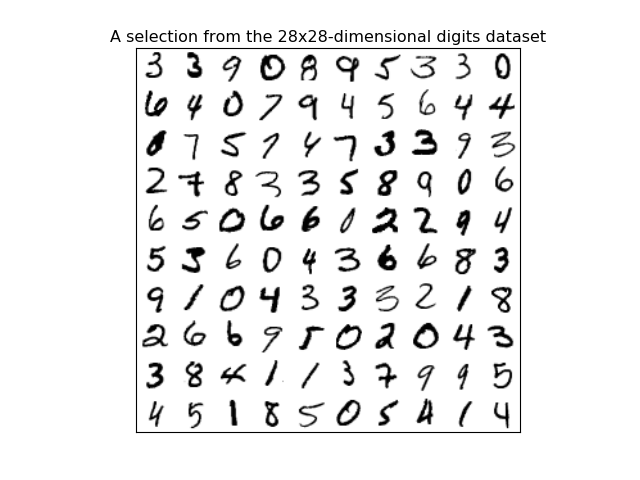

In [3]:
#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 10
img = np.zeros((30 * n_img_per_row, 30 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 30 * i + 1
    for j in range(n_img_per_row):
        iy = 30 * j + 1
        img[ix:ix + 28, iy:iy + 28] = X[i * n_img_per_row + j].reshape((28, 28))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 28x28-dimensional digits dataset')

In [28]:
X.shape[0]

100

<IPython.core.display.Javascript object>


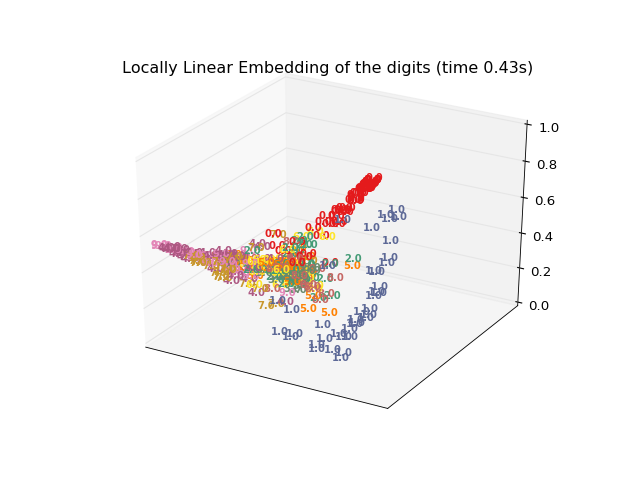

Computing LLE embedding
Done. Reconstruction error: 0.00670859


In [17]:
#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
plt.figure()
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(10, n_components=3,
                                      method='standard')
t0 = time()
X_lle1 = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_3D_embedding(X_lle1,
               "Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))

<IPython.core.display.Javascript object>


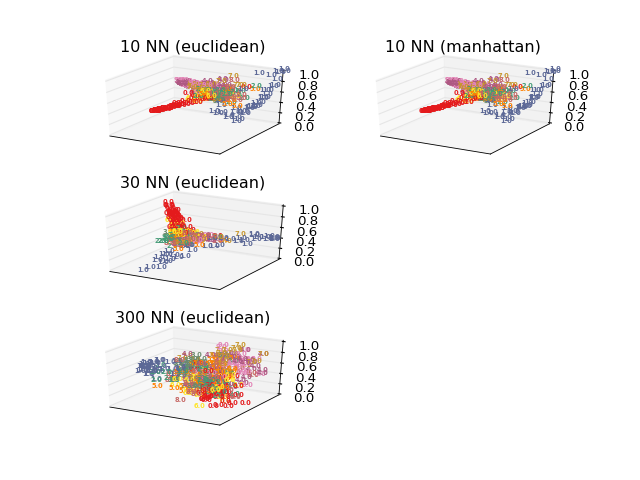

Computing 3D LLE embedding
euclidean
0.121756962748
hamming
euclidean
euclidean


In [26]:
#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
plt.figure()
print("Computing 3D LLE embedding")
t0 = time()

X_lle_10, M, er10 = lle(X, 10, 3)
print(er10)
X_lle_10_L1, M, er10l1 = lle(X, 10, 3, 'hamming')
X_lle_30, M, er30 = lle(X, 30, 3)
X_lle_300, M, er300 = lle(X, 300, 3)

plot_3D_embedding(X_lle_10,
               "10 NN (euclidean)", 321)
plot_3D_embedding(X_lle_10_L1,
               "10 NN (manhattan)", 322)
plot_3D_embedding(X_lle_30,
               "30 NN (euclidean)", 323)
plot_3D_embedding(X_lle_300,
               "300 NN (euclidean)", 325)

<IPython.core.display.Javascript object>


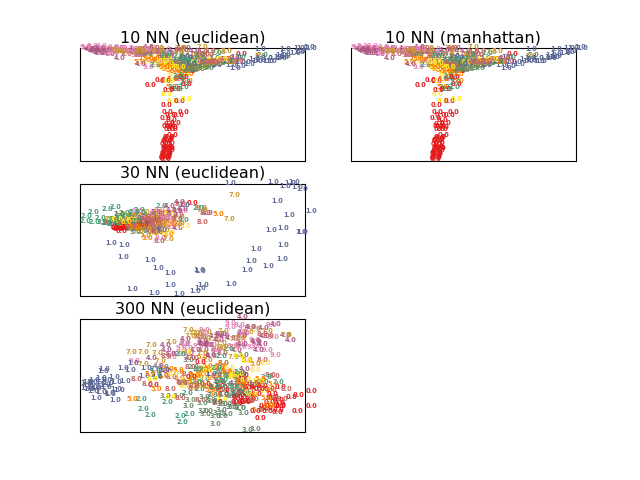

Computing 2D LLE embedding
euclidean
0.12323614076
hamming
euclidean
0.660424400078
euclidean
271.521586967
(400, 10)
(400, 10)
(400, 30)
(400, 300)


In [20]:
#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
plt.figure()
print("Computing 2D LLE embedding")
t0 = time()

X_lle_10, M, er10 = LLE(X, 10, 2)
print(er10)
X_lle_10_L1, M, er10l1 = LLE(X, 10, 2, 'hamming')
X_lle_30, M, er30 = LLE(X, 30, 2)
print(er30)
X_lle_300, M, er300 = LLE(X, 300, 2)
print(er300)
# print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_2D_embedding(X_lle_10,
               "10 NN (euclidean)", 321)
plot_2D_embedding(X_lle_10_L1,
               "10 NN (manhattan)", 322)
plot_2D_embedding(X_lle_30,
               "30 NN (euclidean)", 323)
plot_2D_embedding(X_lle_300,
               "300 NN (euclidean)", 325)

<IPython.core.display.Javascript object>


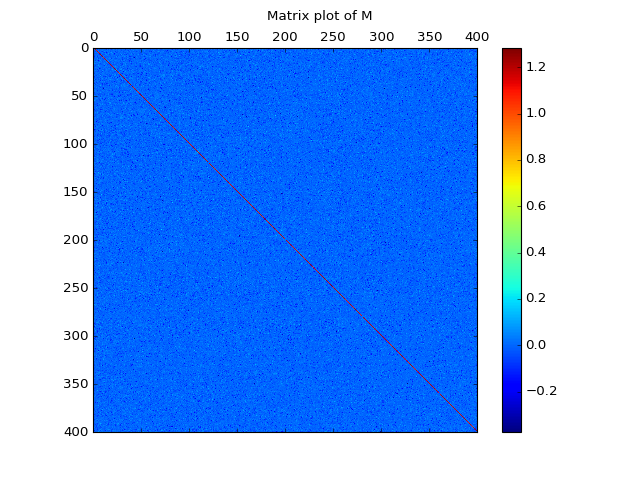

(400,)


<IPython.core.display.Javascript object>


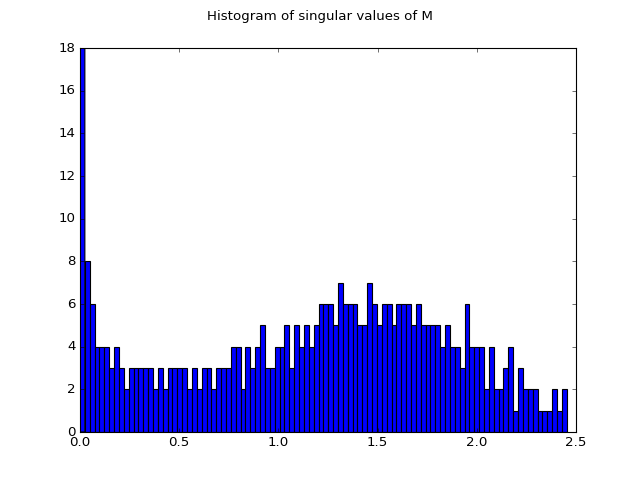

[18, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]


<IPython.core.display.Javascript object>


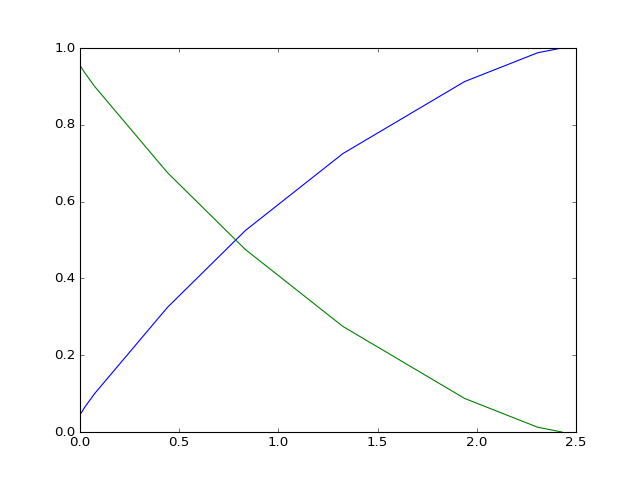

base: [  1.01081194e-15   2.45340489e-02   4.90680979e-02   7.36021468e-02
   9.81361957e-02   1.22670245e-01   1.47204294e-01   1.71738343e-01
   1.96272391e-01   2.20806440e-01   2.45340489e-01   2.69874538e-01
   2.94408587e-01   3.18942636e-01   3.43476685e-01   3.68010734e-01
   3.92544783e-01   4.17078832e-01   4.41612881e-01   4.66146930e-01
   4.90680979e-01   5.15215028e-01   5.39749077e-01   5.64283126e-01
   5.88817174e-01   6.13351223e-01   6.37885272e-01   6.62419321e-01
   6.86953370e-01   7.11487419e-01   7.36021468e-01   7.60555517e-01
   7.85089566e-01   8.09623615e-01   8.34157664e-01   8.58691713e-01
   8.83225762e-01   9.07759811e-01   9.32293860e-01   9.56827908e-01
   9.81361957e-01   1.00589601e+00   1.03043006e+00   1.05496410e+00
   1.07949815e+00   1.10403220e+00   1.12856625e+00   1.15310030e+00
   1.17763435e+00   1.20216840e+00   1.22670245e+00   1.25123650e+00
   1.27577054e+00   1.30030459e+00   1.32483864e+00   1.34937269e+00
   1.37390674e+00   1.398440

In [27]:
data = M#X_lle1[:100,:]#np.random.random((4,4))
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)
fig.suptitle('Matrix plot of M')

U, s, V = np.linalg.svd(M, full_matrices=True)
print(s.shape)
fig = plt.figure()
_ = plt.hist(s, bins=100)
values, base = np.histogram(s, bins=100)
values = sorted(values, reverse=True)
print(values)
fig.suptitle('Histogram of singular values of M')

plt.figure()
cumulative = np.cumsum(values/sum(values))
print("base:", base[:-1])
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')
plt.plot(base[:-1], 1-cumulative, c='green')

Computing modified LLE embedding


<IPython.core.display.Javascript object>


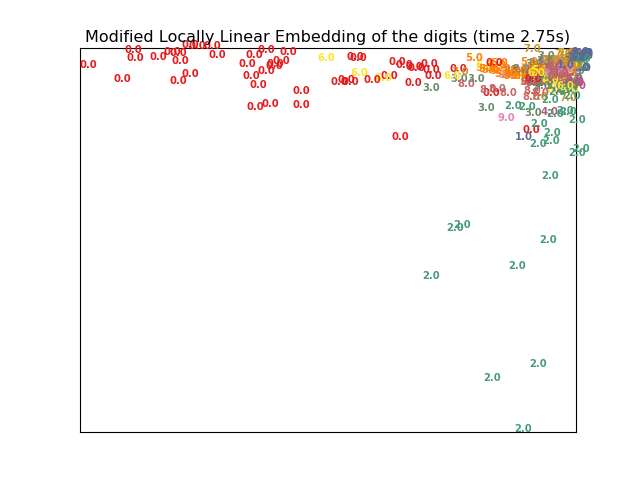

(400, 2)


In [117]:
#----------------------------------------------------------------------
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
# print("Done. Reconstruction error: %g" % clf.recontstruction_error_)
plot_2D_embedding(X_mlle,
               "Modified Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))